In [8]:
%matplotlib notebook
import matplotlib.pyplot as plt

from picar import front_wheels, back_wheels
from picar.SunFounder_PCA9685 import Servo
import picar
from time import sleep
import cv2
import cv2.cv as cv
import numpy as np
import picar
from math import *
picar.setup()
import numpy as np

bw = back_wheels.Back_Wheels()
fw = front_wheels.Front_Wheels()
pan_servo = Servo.Servo(1)
tilt_servo = Servo.Servo(2)
picar.setup()
# - left
# + right
# to be measured directly on the picar
offset = 8
# pan_servo.offset = 10
# tilt_servo.offset = 0
initial_angle_fw=90+offset
bw.speed = 0
fw.turn(initial_angle_fw)
pan_servo.write(90)
tilt_servo.write(90)

# motor_speed = 70
# 70i*3=127cm, i= 1.27/210 m/s
# 70i=1.27/3=0.42333333333333334m/s
# 40i~100i=0.2419047619~0.60476190476 m/s
L=0.14
true_speed_unit=1.2/210
MAX_SPEED=100*true_speed_unit
MIN_SPEED=70*true_speed_unit
MIN_RADIAN=1.0/180*pi
MAX_TRUN_LEFT=(initial_angle_fw-120)*pi/180
MAX_TRUN_RIGHT=(initial_angle_fw-60)*pi/180

DEBUG "back_wheels.py": Set debug off
DEBUG "TB6612.py": Set debug off
DEBUG "TB6612.py": Set debug off
DEBUG "PCA9685.py": Set debug off
DEBUG "front_wheels.py": Set debug off
DEBUG "front_wheels.py": Set wheel debug off
DEBUG "Servo.py": Set debug off


In [9]:
# Controllers. 
def controller(current_position_pose,waypoint,L,precision,v_min,v_max,k_rho=1,k_alpha=1*5,k_beta=-1*2):
    """controller that takes the current position and desired position, then yields a control signal for v and gamma.
    Automatically round to the max/min speed if exceeding the limits. This is unstable."""
    (x,y,theta)=current_position_pose
    (xg,yg,thetag)=waypoint
    delta_x=xg-x
    delta_y=yg-y
    rho=sqrt(delta_x**2+delta_y**2)
    if rho<=precision:
        return 0,0
    alpha=atan2(delta_y,delta_x)-theta
    beta=-theta-alpha+thetag
    if -pi/2<alpha<=pi/2:
        direction=1
    else:
        direction=-1
        alpha_prime=-pi-beta
        beta_prime=-pi-alpha
        alpha=alpha_prime
        beta=beta_prime
    # Control signal
    v=k_rho*rho*direction
    if v==0:
        return 0,0
    if abs(v)<v_min:
        v=v_min*direction
    if abs(v)>v_max:
        v=v_max*direction
    omega=(k_alpha*alpha+k_beta*beta)
    gamma=atan(omega*L/abs(v))
    
    print v*direction,omega*direction,gamma
    return v*direction,gamma
def controller_cs(current_position_pose,waypoint,L,precision,v_min,k_rho=1.0,k_alpha=1*4.5,k_beta=-1*2.5):
    """controller that takes the current position and desired position, then yields a control signal for v and gamma.
    Keep using constant speed v_min as the speed output. It is stable."""
    (x,y,theta)=current_position_pose
    (xg,yg,thetag)=waypoint
    delta_x=xg-x
    delta_y=yg-y
    rho=sqrt(delta_x**2+delta_y**2)
    if rho<=precision:
        return 0,0
    alpha=atan2(delta_y,delta_x)-theta
    beta=-theta-alpha+thetag
    if -pi/2<alpha<=pi/2:
        direction=1
    else:
        direction=-1
        alpha_prime=-pi-beta
        beta_prime=-pi-alpha
        alpha=alpha_prime
        beta=beta_prime
    # Control signal
    k=v_min/rho
    ratio=k/k_rho
    k_alpha=k_alpha*ratio
    k_beta=k_beta*ratio
    v=v_min*direction
    if v==0:
        return 0,0
    omega=(k_alpha*alpha+k_beta*beta)
    gamma=atan(omega*L/abs(v))
#     gamma=round(abs(gamma))
    gamma=np.clip(gamma,MAX_TRUN_LEFT ,MAX_TRUN_RIGHT)
    print v*direction,omega*direction,gamma
    return v*direction,gamma
def isclose(a, b, rel_tol=5e-01, abs_tol=0.1):
    """Approximatiy check for two coordinates pair. Determine if the two coordinates are close enough"""
    x,y,_=a
    xg,yg,_=b
    deltad=sqrt((xg-x)**2+(yg-y)**2)
    return abs(deltad-0) <= max(rel_tol * max(abs(deltad), abs(0)), abs_tol)

In [10]:
# load the waypoints
waypoints=[]
with open("waypoints.txt", "r") as filestream:
    for line in filestream:
        currentline = line.rstrip().split(",")
#         print tuple([float(i) for i in currentline])
        waypoints.append(tuple([float(i) for i in currentline]))

In [11]:
# set debug_mode to True if not executing on the car
debug_mode=True

In [15]:
# for manually assignment of initial position_pose
# initial_position_pose=(0.0,0.0,0.0)

initial_position_pose=waypoints[0]
fw.turn(initial_angle_fw)

current_position_pose=initial_position_pose
current_angle_fw=initial_angle_fw
archived_x_y_theta=[]

deltat=0.05
for waypoint in waypoints:
    print 'heading to ' +str(waypoint)
    reached=False
    while not reached:
        x,y,theta=current_position_pose
#         v,gamma=controller(current_position_pose,waypoint,L,deltat*MIN_SPEED,MIN_SPEED,MAX_SPEED)
        v,gamma=controller_cs(current_position_pose,waypoint,L,deltat*MIN_SPEED,MIN_SPEED)
        if v<0:
            direction=-1
        else:
            direction=1
        v=abs(v)
#         count as no turnning
#         if abs(gamma)<3*MIN_RADIAN:
#             gamma=0
        if not debug_mode:
            fw.turn(current_angle_fw-gamma*180/pi)
#         current_angle_fw=current_angle_fw-gamma*180/pi
        print 'turning angle: '+str(current_angle_fw-gamma*180/pi)
        motor_speed=int(round(abs(v)/true_speed_unit))
        if not debug_mode:
            bw.speed = motor_speed
        true_speed=motor_speed*true_speed_unit
        if direction==1:
            bw.backward()
        elif direction==-1:
            bw.forward()
        if not debug_mode:
            sleep(deltat)
        bw.stop()
#         if gamma==0:
#             delta_position_pose=(true_speed*cos(theta)*deltat,true_speed*sin(theta)*deltat,0)
#         else:
#             Rb=L/tan(gamma)
#             K=true_speed/Rb
#             delta_position_pose=(Rb*sin(K*deltat),Rb*(1-cos(K*deltat)),K*deltat)
        delta_position_pose=(true_speed*cos(theta)*deltat*direction,true_speed*sin(theta)*deltat*direction,true_speed/L*tan(gamma)*deltat*direction)
#         print delta_position_pose
        current_position_pose=tuple(map(sum, zip(current_position_pose, delta_position_pose)))
        archived_x_y_theta.append(current_position_pose)
        print current_position_pose
        if(isclose(current_position_pose,waypoint,abs_tol=deltat*MIN_SPEED) or v==0):
            reached=True
            print str(waypoint)+' reached'
            fw.turn(current_angle_fw)
    if not debug_mode:
        raw_input("Press Enter to continue...")

        

heading to (0.0, 0.0, 0.0)
turning angle: 98.0
(0.0, 0.0, 0.0)
(0.0, 0.0, 0.0)
(0.0, 0.0, 0.0) reached
heading to (1.0, 0.0, 0.0)
0.4 0.0 0.0
turning angle: 98.0
(0.020000000000000004, 0.0, 0.0)
(0.020000000000000004, 0.0, 0.0)
0.4 0.0 0.0
turning angle: 98.0
(0.020000000000000004, 0.0, 0.0)
(0.04000000000000001, 0.0, 0.0)
0.4 0.0 0.0
turning angle: 98.0
(0.020000000000000004, 0.0, 0.0)
(0.06000000000000001, 0.0, 0.0)
0.4 0.0 0.0
turning angle: 98.0
(0.020000000000000004, 0.0, 0.0)
(0.08000000000000002, 0.0, 0.0)
0.4 0.0 0.0
turning angle: 98.0
(0.020000000000000004, 0.0, 0.0)
(0.10000000000000002, 0.0, 0.0)
0.4 0.0 0.0
turning angle: 98.0
(0.020000000000000004, 0.0, 0.0)
(0.12000000000000002, 0.0, 0.0)
0.4 0.0 0.0
turning angle: 98.0
(0.020000000000000004, 0.0, 0.0)
(0.14, 0.0, 0.0)
0.4 0.0 0.0
turning angle: 98.0
(0.020000000000000004, 0.0, 0.0)
(0.16000000000000003, 0.0, 0.0)
0.4 0.0 0.0
turning angle: 98.0
(0.020000000000000004, 0.0, 0.0)
(0.18000000000000005, 0.0, 0.0)
0.4 0.0 0.0

(-0.0003316409355447341, 0.019997250168207404, 0.04561611875067112)
(1.1960764094317229, 0.2806174603438538, 1.6329952523285927)
0.4 0.850176932232 0.289218531393
turning angle: 81.4289987942
(-0.0012431765678890272, 0.01996132540742352, 0.04250884661160899)
(1.1948332328638338, 0.30057878575127733, 1.6755040989402017)
0.4 0.789222231864 0.269507310582
turning angle: 82.5583685558
(-0.002090330918595633, 0.019890462957175312, 0.03946111159318173)
(1.1927429019452382, 0.32046924870845267, 1.7149652105333835)
0.4 0.729342904949 0.249932495529
turning angle: 83.679922843
(-0.0028733997090318987, 0.01979251308227774, 0.03646714524746617)
(1.1898695022362062, 0.3402617617907304, 1.7514323557808495)
0.4 0.670449081641 0.230487055677
turning angle: 84.7940644773
(-0.0035931058055644473, 0.019674592515984142, 0.03352245408205419)
(1.1862763964306418, 0.35993635430671456, 1.7849548098629038)
0.4 0.612473194218 0.211169727696
turning angle: 85.9008658421
(-0.00425050421357735, 0.0195431116747144

(0.016322737918695058, 0.011557172095179452, -0.05771803226216526)
(1.1542623890757266, 1.2764841383466183, 0.5583843949303204)
0.4 -2.12387242493 -0.383972435439
turning angle: 120.0
(0.016962243840211225, 0.010596333512362492, -0.05771803226216526)
(1.171224632915938, 1.2870804718589808, 0.5006663626681552)
0.4 -2.0920093899 -0.383972435439
turning angle: 120.0
(0.0175452579158481, 0.00960020440753058, -0.05771803226216526)
(1.188769890831786, 1.2966806762665113, 0.44294833040598997)
0.4 -2.05956430916 -0.383972435439
turning angle: 120.0
(0.01806983844840946, 0.008572102335389103, -0.05771803226216526)
(1.2068397292801956, 1.3052527786019004, 0.3852302981438247)
0.4 -2.02629213407 -0.383972435439
turning angle: 120.0
(0.018534238350488938, 0.007515451334900995, -0.05771803226216526)
(1.2253739676306845, 1.3127682299368013, 0.32751226588165944)
0.4 -1.99191825051 -0.383972435439
turning angle: 120.0
(0.01893691096305123, 0.0064337705257080935, -0.05771803226216526)
(1.244310878593735

(0.019369016558630676, -0.0049840944565177295, 0.0633333110230897)
(1.9205096598167792, 1.0066234972837984, -0.18852567236900603)
0.4 1.33610082907 0.437422267028
turning angle: 72.9375502342
(0.019645632152820166, -0.0037482178853527983, 0.0668050414536621)
(1.9401552919695995, 1.0028752793984457, -0.12172063091534392)
0.4 1.41324203009 0.459346172519
turning angle: 71.6814029792
(0.019852023715819157, -0.002428405729394032, 0.07066210150471063)
(1.9600073156854185, 1.0004468736690517, -0.051058529410633297)
0.4 1.51567700517 0.487738666703
turning angle: 70.0546328926
(0.019973935928844135, -0.0010207269519462707, 0.07578385025860623)
(1.9799812516142627, 0.9994261467171055, 0.024725320847972937)
0.4 1.78442687962 0.558275228414
turning angle: 66.0131856052
(0.019993886896531986, 0.0004944560331178584, 0.08922134398105448)
(1.9999751385107947, 0.9999206027502233, 0.11394666482902742)
(2.0, 1.0, 0.0) reached
heading to (2.0, 2.0, -1.57)
0.4 5.76259857543 0.663225115758
turning angle: 

turning angle: 106.179863554
(-0.0195312500015998, -0.004304680403352601, -0.02053478203466681)
(1.2856795341382419, 1.083924240981374, 3.337989331722994)
0.4 0.414418003338 -0.144041769143
turning angle: 106.252985445
(-0.01961552166571472, -0.003902731067070406, -0.020720900166909473)
(1.266064012472527, 1.0800215099143036, 3.3172684315560845)
0.4 0.417875332427 -0.145226696768
turning angle: 106.320876797
(-0.019692173112406806, -0.0034954710857054067, -0.020893766621361595)
(1.2463718393601202, 1.0765260388285982, 3.296374664934723)
0.4 0.421099358767 -0.146331294854
turning angle: 106.384165606
(-0.01976090320819002, -0.003083294406401274, -0.021054967938361573)
(1.2266109361519302, 1.073442744422197, 3.2753196969963616)
0.4 0.424117876437 -0.147365156849
turning angle: 106.443401535
(-0.019821437118895523, -0.0026665765583742175, -0.02120589382183996)
(1.2067894990330346, 1.0707761678638228, 3.254113803174522)
0.4 0.42695528169 -0.148336697445
turning angle: 106.499066711
(-0.019

(-0.008157630309721102, 0.018260697350592055, -0.026389586534284772)
(0.3219908718025878, 1.5515575203042058, 1.9645393297660854)
0.4 0.530031405519 -0.183425803013
turning angle: 108.509524366
(-0.007672953623366924, 0.01846959075598754, -0.026501570275948162)
(0.31431791817922083, 1.5700271110601933, 1.9380377594901372)
0.4 0.532299346069 -0.184193064286
turning angle: 108.553485199
(-0.007180843432069527, 0.018666426749758613, -0.026614967303451916)
(0.3071370747471513, 1.588693537809952, 1.9114227921866853)
0.4 0.534595836785 -0.184969760843
turning angle: 108.597986634
(-0.006681552596661993, 0.018850911248479197, -0.0267297918392326)
(0.3004555221504893, 1.6075444490584312, 1.8846930003474527)
0.4 0.536921134684 -0.185755970332
turning angle: 108.643033119
(-0.006175344881502872, 0.01902275257670394, -0.02684605673417815)
(0.2942801772689864, 1.6265672016351351, 1.8578469436132745)
0.4 0.539275467854 -0.186551760351
turning angle: 108.688628529
(-0.005662495142070987, 0.019181661

(0.7963996550207455, 2.629661308534368, 0.43388809949704293)
0.4 -0.412692170005 -0.143450123016
turning angle: 106.219086619
(0.01814676096096106, 0.008408035836373423, -0.020634608500238905)
(0.8145464159817065, 2.6380693443707415, 0.41325349099680403)
0.4 -0.41331423383 -0.143663389152
turning angle: 106.231305869
(0.018316381985872807, 0.00803182114763484, -0.020665711691481473)
(0.8328627979675793, 2.646101165518376, 0.39258777930532257)
0.4 -0.414005213536 -0.143900266736
turning angle: 106.244877955
(0.01847844240741047, 0.007651611999834701, -0.020700260676816924)
(0.8513412403749898, 2.653752777518211, 0.37188751862850566)
0.4 -0.414763895877 -0.144160335009
turning angle: 106.259778769
(0.01863286258667855, 0.007267491439689137, -0.020738194793850195)
(0.8699741029616683, 2.6610202689579, 0.35114932383465547)
0.4 -0.415589160651 -0.144443204739
turning angle: 106.275986011
(0.018779559837625553, 0.00687954448383331, -0.020779458032553332)
(0.8887536627992939, 2.66789981344173

(1.692287739019638, 2.573071704049364, -0.620449163758941)
0.4 -0.509890229348 -0.176602400317
turning angle: 108.11857219
(0.01627234789270636, -0.011628013332411301, -0.025494511467378418)
(1.7085600869123443, 2.5614436907169527, -0.6459436752263195)
0.4 -0.513584948976 -0.177855357504
turning angle: 108.190361349
(0.015970641502926406, -0.012039045227301237, -0.02567924744879377)
(1.7245307284152707, 2.5494046454896515, -0.6716229226751133)
0.4 -0.517363779558 -0.179136254907
turning angle: 108.263751364
(0.015656256436777424, -0.012445145012649131, -0.025868188977906305)
(1.7401869848520481, 2.5369595004770025, -0.6974911116530196)
0.4 -0.521228417556 -0.180445623837
turning angle: 108.338772677
(0.015329120973621378, -0.01284593516160195, -0.026061420877791792)
(1.7555161058256694, 2.5241135653154005, -0.7235525325308114)
0.4 -0.525180612264 -0.181784010976
turning angle: 108.415456612
(0.01498917008996486, -0.013241026395793602, -0.026259030613195757)
(1.7705052759156343, 2.51087

(-0.018899776659650355, -0.0065420518352681785, 0.03299605222555408)
(1.2092973034667953, 1.5982544515090795, -2.775360736470138)
0.4 0.686504546591 0.235806491633
turning angle: 84.4892832476
(-0.018673666410138384, -0.007161995727649493, 0.034325227329526975)
(1.190623637056657, 1.59109245578143, -2.7410355091406107)
0.4 0.711895183312 0.244191039206
turning angle: 84.0088840586
(-0.01841687777586087, -0.007798628917252185, 0.0355947591656206)
(1.172206759280796, 1.5832938268641779, -2.70544074997499)
0.4 0.736208670077 0.252187203153
turning angle: 83.5507376121
(-0.018127680331747276, -0.008449094968692387, 0.03681043350387074)
(1.154079078949049, 1.5748447318954855, -2.6686303164711194)
0.4 0.75955719392 0.259835135451
turning angle: 83.1125433695
(-0.017804455527082343, -0.009110508404263022, 0.03797785969599469)
(1.1362746234219665, 1.5657342234912224, -2.630652456775125)
0.4 0.782049217316 0.267173235503
turning angle: 82.6921012068
(-0.0174457027856177, -0.009779951652022162, 

(-0.01988281296037645, -0.002161885469373054, -0.05771803226216526)
(0.819723324078779, 0.3772463574991265, -3.0910047955266178)
0.4 -2.24407492319 -0.383972435439
turning angle: 120.0
(-0.01997441414332813, -0.0010113256798941208, -0.05771803226216526)
(0.7997489099354509, 0.37623503181923235, -3.148722827788783)
0.4 -2.14695236566 -0.383972435439
turning angle: 120.0
(-0.01999949160831279, 0.00014260227567065246, -0.05771803226216526)
(0.7797494183271381, 0.376377634094903, -3.2064408600509484)
0.4 -2.03929709981 -0.383972435439
turning angle: 120.0
(-0.019957961836174574, 0.0012960553019834287, -0.05771803226216526)
(0.7597914564909635, 0.3776736893968864, -3.2641588923131137)
0.4 -1.92027660827 -0.383972435439
turning angle: 120.0
(-0.01984996313959836, 0.002445191885432843, -0.05771803226216526)
(0.739941493351365, 0.38011888128231924, -3.321876924575279)
0.4 -1.78912521805 -0.383972435439
turning angle: 120.0
(-0.019675855202466744, 0.0035861848880896206, -0.05771803226216526)
(0

0.4 1.42097766632 0.461519095904
turning angle: 71.55690364
(0.008397592200888855, -0.018151596217070576, 0.07104888331622264)
(-0.22191862711218802, 0.13623334753906646, -1.0664347769217595)
0.4 1.45157739316 0.470068509896
turning angle: 71.067058301
(0.009664971730065034, -0.017509663659163868, 0.0725788696577707)
(-0.21225365538212299, 0.11872368387990259, -0.9938559072639888)
0.4 1.48421515403 0.479106186851
turning angle: 70.5492375548
(0.010909243019298331, -0.016762709111175635, 0.07421075770152663)
(-0.20134441236282466, 0.10196097476872695, -0.9196451495624621)
0.4 1.51911072059 0.488676068791
turning angle: 70.0009237092
(0.012122048761568612, -0.015907731888052206, 0.07595553602960281)
(-0.18922236360125605, 0.08605324288067474, -0.8436896135328593)
0.4 1.55652503711 0.498829603434
turning angle: 69.4191690271
(0.013294216871579504, -0.014942014515165315, 0.07782625185565324)
(-0.17592814672967655, 0.07111122836550943, -0.765863361677206)
0.4 1.5967745619 0.509628511763
tur

In [13]:
bw.stop()
fw.turn(initial_angle_fw)

<IPython.core.display.Javascript object>


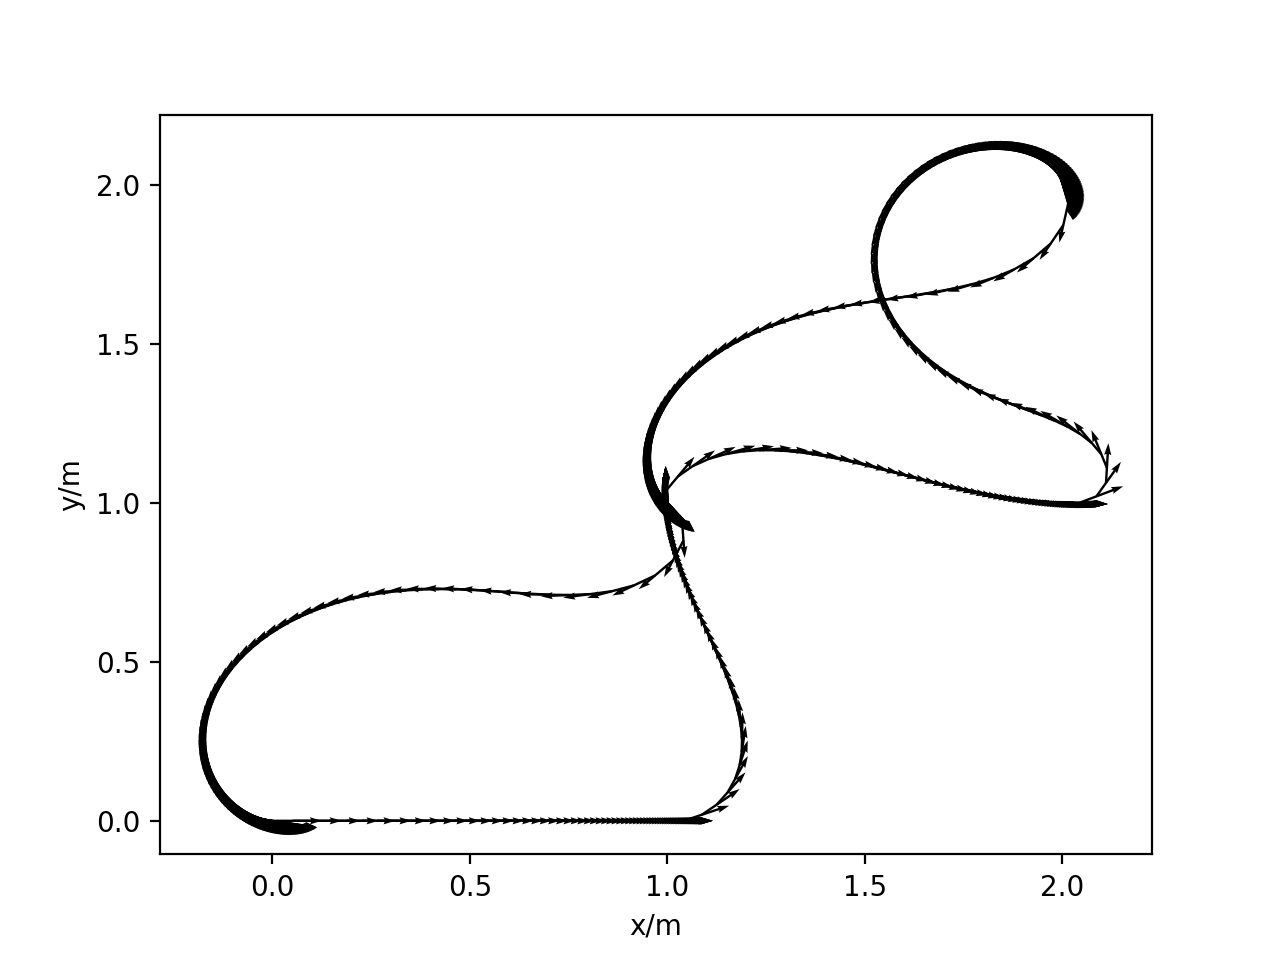

In [16]:
# Visualization
ptdata=np.array(archived_x_y_theta)
fig, ax=plt.subplots()

ax.quiver(ptdata[:,0],ptdata[:,1],np.cos(ptdata[:,2]),np.sin(ptdata[:,2]),
          angles='xy', scale_units='xy', scale=8)
ax.set_xlabel('x/m')
ax.set_ylabel('y/m')
# fig.savefig('ideal_traj.pdf', bbox_inches='tight')


<IPython.core.display.Javascript object>


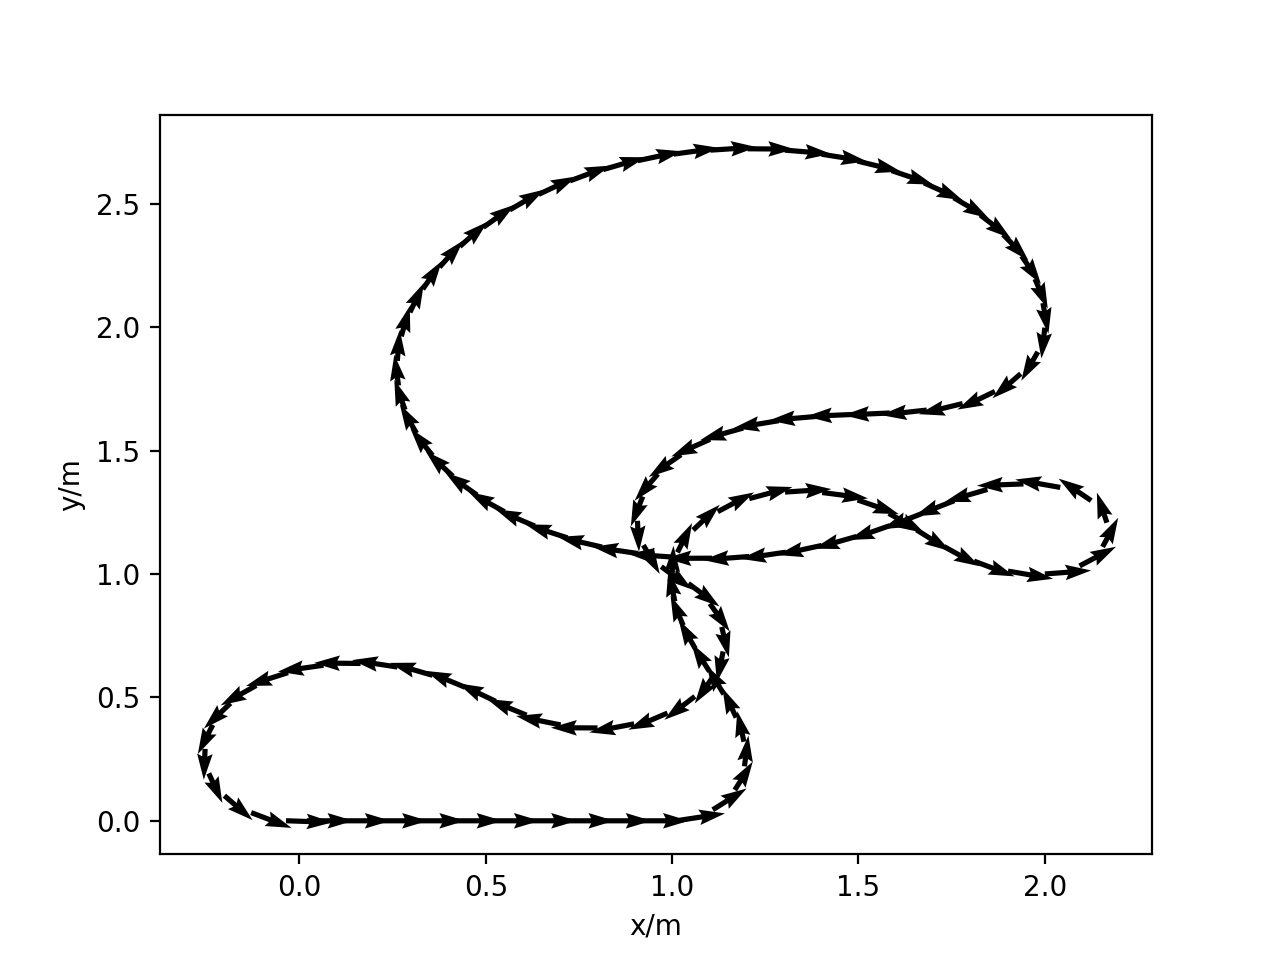

In [16]:
ptdata=np.array(archived_x_y_theta)
fig, ax=plt.subplots()
sample=5
ax.quiver(ptdata[:,0][1::sample],ptdata[:,1][1::sample],np.cos(ptdata[:,2][1::sample]),np.sin(ptdata[:,2][1::sample]),
          angles='xy', scale_units='xy', scale=8)
ax.set_xlabel('x/m')
ax.set_ylabel('y/m')
# fig.savefig('acutal_used.pdf', bbox_inches='tight')